INTRODUCTION

This report presents an analysis of the Data Science Stack Exchange site using the most recent data dump. The goal is to gain insights into the data, with a focus on text extraction and visualization.
We will be additionally using regex patterns to extract the necessary data.


Data Conversion

The following Python code converts XML data to CSV format with the help of the package 'xml'.

In [1]:
import xml.etree.ElementTree as ET
import pandas as pd

def xml_to_csv(xml_file, csv_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    
    columns = root[0].attrib.keys()
    data = [element.attrib for element in root]
    df = pd.DataFrame(data, columns=columns)
    df.to_csv(csv_file, index=False)

xml_to_csv('Badges.xml', 'Badges.csv')
xml_to_csv('Comments.xml', 'Comments.csv')
xml_to_csv('PostHistory.xml', 'PostHistory.csv')
xml_to_csv('PostLinks.xml', 'PostLinks.csv')
xml_to_csv('Posts.xml', 'Posts.csv')
xml_to_csv('Tags.xml', 'Tags.csv')
xml_to_csv('Users.xml', 'Users.csv')
xml_to_csv('Votes.xml', 'Votes.csv')
## Data Loading

#The following Python code converts CSV data to pandas DataFrame.

badges_df = pd.read_csv('Badges.csv')
comments_df = pd.read_csv('Comments.csv')
posthist_df = pd.read_csv('PostHistory.csv')
postlink_df = pd.read_csv('PostLinks.csv')
posts_df = pd.read_csv('Posts.csv')
tags_df = pd.read_csv('Tags.csv')
user_df = pd.read_csv('Users.csv')
votes_df = pd.read_csv('Votes.csv')

/var/folders/y8/lzjj81hn3r1bgm__n89fz6zh0000gn/T/ipykernel_83797/85920776.py:28: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  posthist_df = pd.read_csv('PostHistory.csv')


The first plot is to find the most repetitive words in titles among the posts that have been posted throughout.
We will bw doing this with the help of 'wordcloud' package.

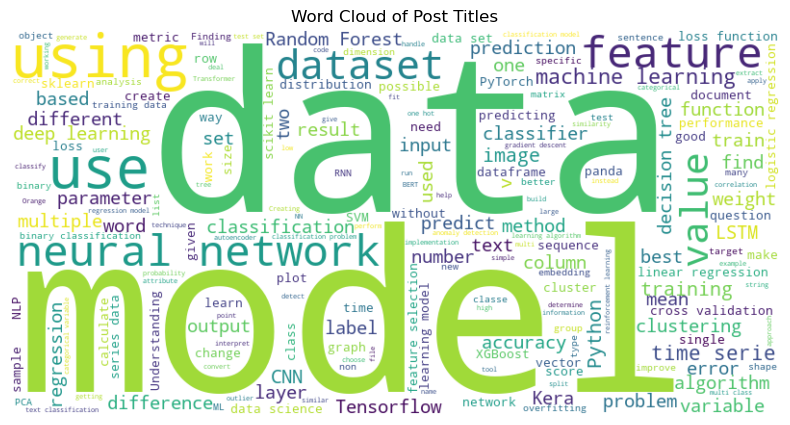

In [2]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = ' '.join(posts_df['Title'].dropna().tolist())

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Post Titles')
plt.savefig('wordcloud.png')  
plt.show()

For the next part, we are going to analyse the tags of the posts data. A little pre-processing is required to remove the tag elements and to analyse them

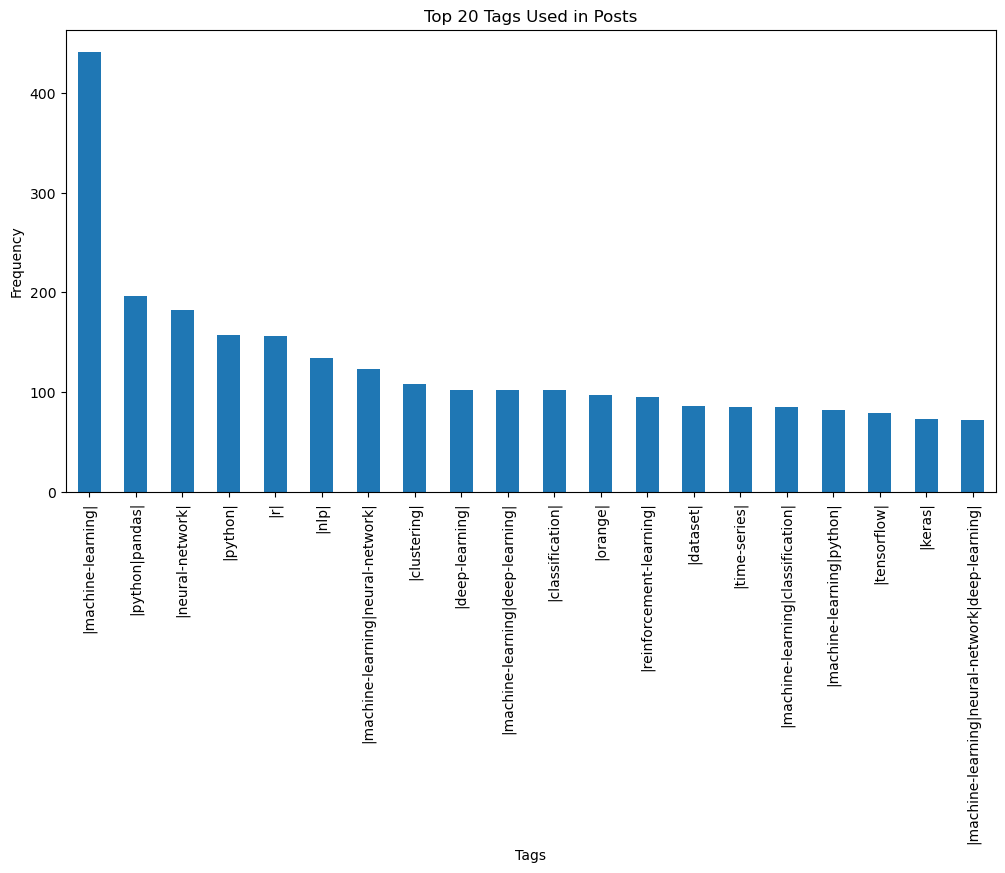

In [3]:
# Extract tags from the posts
tags_series = posts_df['Tags'].dropna().apply(lambda x: x.strip('<>').split('><')).explode()
# Count the occurrences of each tag
tag_counts = tags_series.value_counts().head(20)
# Plot the top tags
plt.figure(figsize=(12, 6))
tag_counts.plot(kind='bar')
plt.title('Top 20 Tags Used in Posts')
plt.xlabel('Tags')
plt.ylabel('Frequency')
plt.savefig('toptags.png')
plt.show()

For the next plot, we will analyse how many characters are usually used to make comments in a post

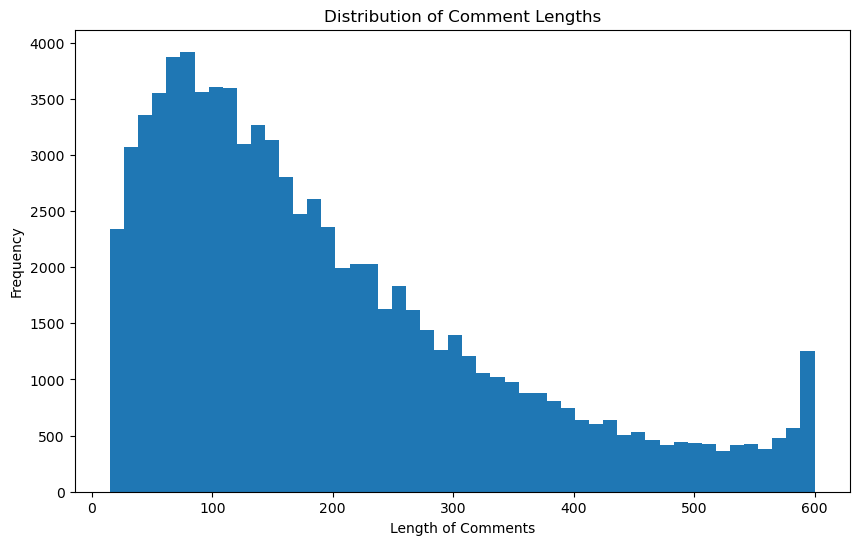

In [4]:
# Calculate comment lengths
comments_df['Length'] = comments_df['Text'].str.len()
# Plot the distribution
plt.figure(figsize=(10, 6))
comments_df['Length'].plot(kind='hist', bins=50)
plt.title('Distribution of Comment Lengths')
plt.xlabel('Length of Comments')
plt.ylabel('Frequency')
plt.savefig('comment_lengths.png')
plt.show()


In this post, we will check the top 10 email domains that are present in the comments. This requires a little pre-processing. We wil be using regex pattern to match the email address domain and retrieve them for analysis.

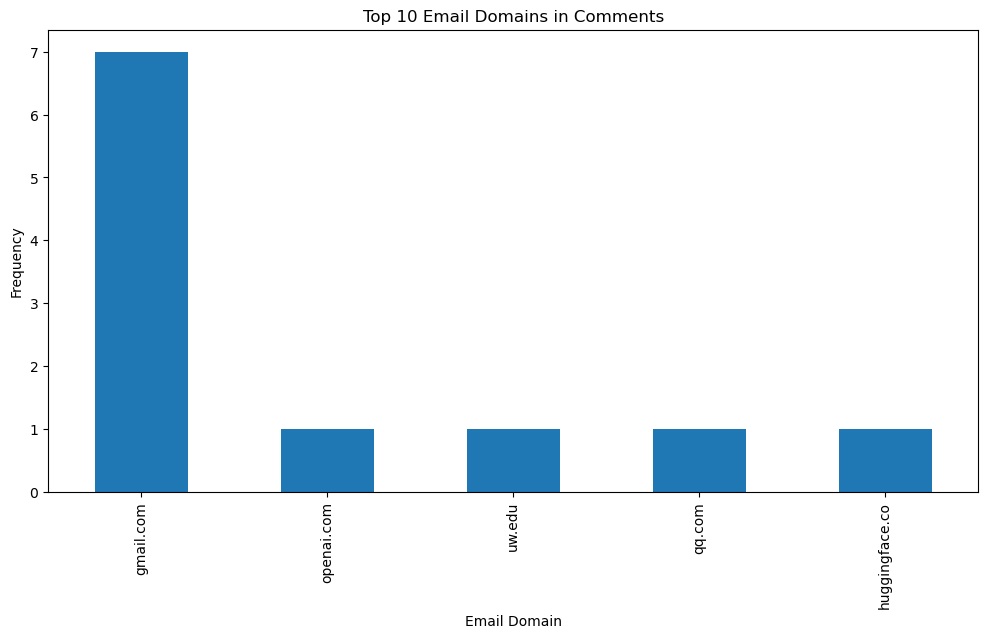

In [5]:
import re
comments_df['Text'] = comments_df['Text'].fillna('')  # Replace NaNs with empty strings
# Regex pattern to extract email addresses
email_pattern = re.compile(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,7}\b')
# Extract email addresses
comments_df['Emails'] = comments_df['Text'].apply(lambda x: email_pattern.findall(x))
# Explode the emails into separate rows
emails_exploded = comments_df['Emails'].explode().dropna()
# Extract domains from email addresses
email_domains = emails_exploded.apply(lambda x: x.split('@')[1])
# Count the occurrences of each domain
domain_counts = email_domains.value_counts().head(10)

# Plot the top 10 email domains
plt.figure(figsize=(12, 6))
domain_counts.plot(kind='bar')
plt.title('Top 10 Email Domains in Comments')
plt.xlabel('Email Domain')
plt.ylabel('Frequency')
plt.savefig('email_domains.png')
plt.show()


Next, we will create a table that shows details such as title of the post, author of the post and his reputation score

In [7]:
from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource,TableColumn,DataTable
from bokeh.layouts import column
output_notebook()
keyword = input("Enter a keyword to filter post titles: ")
# Filter the posts_df based on the keyword
filtered_posts_df = posts_df[posts_df['Title'].str.contains(keyword, case=False, na=False)]
# Merge DataFrames on OwnerUserId and Id
merged_df = pd.merge(filtered_posts_df, user_df, left_on='OwnerUserId', right_on='Id')
# Drop rows with NaN values
merged_df.dropna(inplace=True)
# Select only the useful columns to display
display_df = merged_df[['Title', 'DisplayName', 'Reputation']]
# Create ColumnDataSource
source = ColumnDataSource(display_df)
# Define columns for DataTable
columns = [
    TableColumn(field='Title', title='Post Title'),
    TableColumn(field='DisplayName', title='User Name'),
    TableColumn(field='Reputation', title='User Reputation')
]

# Create DataTable
data_table = DataTable(source=source, columns=columns, width=800, height=280)
# Display the DataTable
show(column(data_table))

Loading BokehJS ...

Enter a keyword to filter post titles:  machine


We will plot the number of comments over the time (monthly) to view when we have received a lot of comments and try to bring out some patterns.
The following Python code uses Bokeh to create an interactive time series plot of the number of comments on posts containing specific keywords in their titles.

In [8]:
# Number of Comments on Posts Over Time Using Bokeh

#The following Python code uses Bokeh to create an interactive time series plot of the number of comments on posts containing specific keywords in their titles.

#```{python}
from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource
from bokeh.layouts import column

output_notebook()
# Regex pattern to find specific keywords in post titles
keywords_pattern = re.compile(r'\bdata science\b|\bmachine learning\b', re.IGNORECASE)
# Filter posts that contain the keywords in the title
keyword_posts = posts_df[posts_df['Title'].str.contains(keywords_pattern, na=False)]

# Merge posts with comments to get the number of comments per post
keyword_posts_comments = keyword_posts.merge(comments_df, left_on='Id', right_on='PostId', suffixes=('_post', '_comment'))
# Convert 'CreationDate' columns to datetime
keyword_posts_comments['CreationDate_post'] = pd.to_datetime(keyword_posts_comments['CreationDate_post'])
keyword_posts_comments['CreationDate_comment'] = pd.to_datetime(keyword_posts_comments['CreationDate_comment'])

# Group by month and count the number of comments
comments_per_month = keyword_posts_comments.resample('M', on='CreationDate_comment').size()
# Prepare the data for Bokeh
source = ColumnDataSource(data={
    'date': comments_per_month.index,
    'comments': comments_per_month.values,
})

# Create the plot
p = figure(title="Number of Comments on Posts Over Time",
           x_axis_label='Date', y_axis_label='Number of Comments',
           x_axis_type='datetime', height=400, width=800)

p.line('date', 'comments', source=source, line_width=2, legend_label='Comments')
p.circle('date', 'comments', source=source, size=5, color='navy', alpha=0.5)

p.legend.location = "top_left"
p.legend.click_policy="hide"

show(p)


Loading BokehJS ...